In [ ]:
#!python -m spacy download en_core_web_md

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,precision_recall_fscore_support,precision_score,recall_score,f1_score,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import os
import csv
import nltk
import spacy
import json

In [ ]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
embedding_file=spacy.load('en_core_web_md')

In [ ]:
#embedding_file('the').vector

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
corpora = '/content/drive/MyDrive/Colab Data/articles'
tagged_data=[]
irrelevant_docs=0
irrelevant_docs_address=[]
df_corpus={'Content':[],'Label':[]}

for subdir, dirs, files in os.walk(corpora):
  for file in files:
    #print(data_file)
    path = os.path.join(subdir, file)
    with open(path,'r') as f:
      data=json.load(f)
      if data['candidateLabels']: #not an empty list thus relevant document

        if data['content']:
          df_corpus['Content'].append(data['content'].replace('\r', '').replace('\t', '').replace('\n','').replace('&#13;',''))
          df_corpus['Label'].append('relevant')
      else:#irrelevant document
        """df_corpus['Content'].append(data['content'])
        df_corpus['Label'].append('irrelevant')"""

        if data['content']:
          df_corpus['Content'].append(data['content'].replace('\r', '').replace('\t', '').replace('\n','').replace('&#13;',''))
          df_corpus['Label'].append('irrelevant')

In [ ]:
data=pd.DataFrame(df_corpus)

In [ ]:
tokenizer=Tokenizer()
label_encoder=LabelEncoder()

In [ ]:
label_encoder.fit(data['Label'])

LabelEncoder()

In [ ]:
X=data['Content']
y=label_encoder.transform(data['Label'])

In [ ]:
cls_2=svm.SVC(kernel='rbf')

In [ ]:
tokenizer.fit_on_texts(X)

In [ ]:
size_of_vocab=len(tokenizer.word_index)+1
size_of_vocab

18021

In [ ]:
embedding_matrix=np.zeros((size_of_vocab,300))
i=0
for word in tokenizer.word_index:
  embedding_vector=embedding_file(word).vector
  if embedding_vector is not None:
    embedding_matrix[i]=embedding_vector
  i=i+1

In [ ]:
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2)

X_train,X_test,y_train,y_test=train_test_split(X_train,y_train,test_size=0.2)

In [ ]:
x_train_seq=tokenizer.texts_to_sequences(X_train)
x_test_seq=tokenizer.texts_to_sequences(X_test)
#x_val_seq=tokenizer.texts_to_sequences(X_val)

In [ ]:
SEQ_LEN=128
x_tr_seq=pad_sequences(x_train_seq,maxlen=SEQ_LEN)
#x_val_seq=pad_sequences(x_val_seq,maxlen=SEQ_LEN)
x_test_seq=pad_sequences(x_test_seq,maxlen=SEQ_LEN)

In [ ]:
x_tr_seq.shape

(321, 128)

In [ ]:
tokenizer.sequences_to_texts(list([x_tr_seq[0]]))

['the eu’s trade notification system traces shows there have been no direct cattle or sheep goat imports into the uk from this region or the neighbouring puy de dome region since 1 august “however as many consignments come through assembly centres it is not always obvious what the place of origin would be and therefore livestock keepers in the uk should be vigilant to possible clinical signs ” said defra “until the origin of disease is understood and the extent of spread it is difficult to assess whether this outbreak signifies an increase in our risk level from low to medium meteorological modelling of recent weather conditions to assess whether the uk has been at risk of incursion in the past two months will be carried out ”']

In [ ]:
model=Sequential()
model.add(Embedding(size_of_vocab,300,weights=[embedding_matrix],input_length=SEQ_LEN,trainable=True))#,weights=[embedding_matrix]
model.add(LSTM(128,return_sequences=True,dropout=0.2))
#model.add(Bidirectional(LSTM(128,return_sequences=True,dropout=0.2)))
model.add(GlobalMaxPool1D())
model.add(Dense(64,activation='relu'))
model.add(Dense(2,activation='softmax'))

In [ ]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['Accuracy'])
es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=3)
mc=ModelCheckpoint('best_model.h5',monitor='val_acc',mode='max',save_best_only=True,verbose=1)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 300)          5406300   
                                                                 
 lstm (LSTM)                 (None, 128, 128)          219648    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 5,634,334
Trainable params: 5,634,334
Non-trainable params: 0
______________________________________________

In [ ]:
cls_2.fit(x_tr_seq,y_train)

SVC()

In [ ]:
y_train

In [ ]:
result = {}
for i in range(2,11):
  kfold = KFold(n_splits=i)
  c_validated = cross_val_score(cls_2,x_tr_seq,y_train,cv=kfold,scoring='f1') 
  result[i] = c_validated.mean()
print(result)

{2: 0.18085106382978725, 3: 0.26209992193598747, 4: 0.20079558123036384, 5: 0.14523684975297874, 6: 0.1713391984359726, 7: 0.18736009985437904, 8: 0.17591514844804318, 9: 0.18596760443307758, 10: 0.1731022073901331}


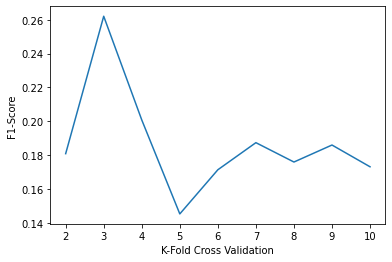

In [ ]:
plt.plot(list(result.keys()),list(result.values()))
plt.ylabel('F1-Score')
plt.xlabel('K-Fold Cross Validation')
plt.show()

In [ ]:
c_validated

array([0.37735849, 0.51345029, 0.63636364, 0.40740741, 0.39622642,
       0.37662338, 0.45142857, 0.36374269, 0.47934919, 0.5       ])

In [ ]:
prediction=cls_2.predict(x_test_seq)

In [ ]:
print(accuracy_score(y_test,prediction))

0.7283950617283951


In [ ]:
precision_score(y_test,prediction,pos_label=1)

0.7272727272727273

In [ ]:
recall_score(y_test,prediction,pos_label=1)

0.2962962962962963

In [ ]:
f1_score(y_test,prediction,pos_label=1)

0.42105263157894735

In [ ]:
BATCH_SIZE=64
epochs=50
history=model.fit(x_tr_seq,y_train,batch_size=BATCH_SIZE,epochs=epochs)#,validation_data=(x_val_seq,y_val),verbose=1,callbacks=[es,mc],validation_steps=1)

Epoch 1/50
6/6 [==============================] - 5s 47ms/step - loss: 0.6680 - Accuracy: 0.6293
Epoch 2/50
6/6 [==============================] - 0s 39ms/step - loss: 0.6347 - Accuracy: 0.6324
Epoch 3/50
6/6 [==============================] - 0s 36ms/step - loss: 0.6178 - Accuracy: 0.7009
Epoch 4/50
6/6 [==============================] - 0s 35ms/step - loss: 0.5986 - Accuracy: 0.6854
Epoch 5/50
6/6 [==============================] - 0s 34ms/step - loss: 0.5756 - Accuracy: 0.6854
Epoch 6/50
6/6 [==============================] - 0s 32ms/step - loss: 0.5559 - Accuracy: 0.7165
Epoch 7/50
6/6 [==============================] - 0s 32ms/step - loss: 0.5395 - Accuracy: 0.6511
Epoch 8/50
6/6 [==============================] - 0s 32ms/step - loss: 0.5097 - Accuracy: 0.6854
Epoch 9/50
6/6 [==============================] - 0s 31ms/step - loss: 0.4449 - Accuracy: 0.8162
Epoch 10/50
6/6 [==============================] - 0s 33ms/step - loss: 0.4479 - Accuracy: 0.8442
Epoch 11/50
6/6 [============

In [ ]:
_,test_acc=model.evaluate(x_test_seq,y_test,batch_size=64)
print(test_acc)

2/2 [==============================] - 1s 16ms/step - loss: 0.3006 - Accuracy: 0.8519
0.8518518805503845


In [ ]:
predictions=model.predict(x_test_seq)

In [ ]:
#predictions.shape

In [ ]:
#y_test.shape

In [ ]:
y_hat=tf.math.argmax(predictions,1)
y_true=y_test
f1_score(y_true,y_hat,average='macro')

0.8333333333333333

In [ ]:
precision_score(y_true,y_hat,average='macro')

0.8333333333333333

In [ ]:
recall_score(y_true,y_hat,average='macro')

0.8333333333333333